# 3_Building footprints classification

Notebook for the 3rd pipeline - building footprints classification. In this notebook, we would like to test the 4-step process:
1. Generate additional features for clustering (rectangularity, polygon turning functions, proximity matrix)
1. Apply Tobler's geography law into clustering footprints (objects that are closed together --> same functions | near things are more relevant than far things)
    1. Proximity-based grouping footprints into building blocks (DBSCAN)
    1. Geography law apply: find footprints with similar shape (turning func, rectangularity) + size (total_area) ==> get majority of types
        1. Same building block
        1. Same area
    1. Apply statistical analysis results to categorize left-over footprints

## Initialization

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

d:\programdata\anaconda3\envs\phoenix\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
import pandas as pd
import numpy as np
import sys
import os
import glob
import re

# Visualization
import matplotlib.pyplot as plt

# import seaborn as sns
# import igraph

# from shapely import wkt
# from shapely.geometry import box, Polygon
# from geopandas import GeoDataFrame
# import hdbscan

In [3]:
# Self-made modules
import helpers as hp
import buildings_classification as bc
# import gemeindeverz

In [4]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Inputs
Define inputs path

In [28]:
buildings_int_path = '../data/02_intermediate/buildings_data/'
buildings_pri_path = '../data/03_primary/buildings_data/'

plz_ags_csv = '../data/01_raw/zuordnung_plz_ort_landkreis.csv'

# Demographics
ags_living_csv = '../data/01_raw/de_living_2019.csv'
ags_population_csv = '../data/01_raw/de_population_2019.csv'

# Community directory dataframe
GV_path = '../data/01_raw/GV/GV100AD_301120.asc'


Demographics data

In [6]:
ags_living = pd.read_csv(ags_living_csv, 
                         sep = ';', 
                         encoding = 'cp1250', 
                         dtype= {'1_Auspraegung_Code':str},
                         low_memory = False)
ags_population = pd.read_csv(ags_population_csv, 
                             sep = ';', 
                             dtype= {'1_Auspraegung_Code':str},
                             encoding = 'cp1250', 
                             low_memory = False)


Geographic data

In [7]:
# Contain local AGS codes (no regional)
plz_ags = pd.read_csv(plz_ags_csv, dtype= {'plz': str, 'ags': str})
plz_ags.shape

(12883, 4)



## Building blocks segmentation with (H)DBSCAN

In the paper ["Proximity-based grouping of buildings in urban blocks"](https://www.researchgate.net/publication/271901065_Proximity-based_grouping_of_buildings_in_urban_blocks_A_comparison_of_four_algorithms), the authors used 2 different approaches to evaluate 4 algorithms in clustering buildings into urban blocks. It concludes that DBSCAN (Density-based spatial clustering of applications with noise) together with ASCDT (An adaptive spatial clustering algorithm based on delaunay triangulation) performed best and their degree of complexity is not hard to implement. Thus, in this project, I implemented HDBSCAN - an extended version of DBSCAN to cluster our OSM building footprints.

### Reason not to use K-means (bonus)

When think of clustering, k-means usually pops right up as the first answer. As the algorithm itself, k-means is designed to minimize variance. 

Since the data is in latitude, longitude format ==> not **linear**, worst case is k-means will never converge (even with Haversine distance). To circumvent this problem, we should use an algorithm that can handle arbitrary distance functions, in particular geodetic distance functions such as Hierarchical clustering, PAM, CLARA, OPTICS and DBSCAN.

(inspired from [*])

### HDBSCAN
HDBSCAN is a clustering algorithm developed by Campello, Moulavi, and Sander[*]. It extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters. Since clusters formed are not radius-based, they can be in non-circular format. Hence, it is more suitable for geo-analytics considering footprints boundaries are not in circular shape.And this is the algorithm we will use to group building footprints together.

Another good read to understand HDBSCAN better from [Author Name]'s article is here https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e


#### Parameters

More details on the official page [HERE](!https://hdbscan.readthedocs.io/en/latest/parameter_selection.html)


For our project, we need to generate a **proximity matrix** for all building footprints in the area. Since we have already gathered and cleaned building objects data from ~10k municipalities in Germany (refer to the previous article), it is better to keep the building blocks grouping it the same granularity level (a.k.a municipality-level - AGS key)

There are 3 parameters for HDBSCAN we need to set:
*Epsilon* (ε)
*MinPts* 


We will start with the baseline from the paper with *ε* = 3 and *MinPts* = 2 then fine-tune them to get optimized values

> If “MinPts (minimum points)” = 2, any 2 or more points within the ε distance away from each other will be considered a cluster.





### References
[*] Ester, M. (2019). A density-based algorithm for discovering clusters in large spatial databases with noise. [online] Psu.edu. Available at: https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.121.9220 [Accessed 2 Jan. 2021].

[*] McInnes, L., Healy, J. and Astels, S. (2017). hdbscan: Hierarchical density based clustering. [online] ResearchGate. Available at: https://www.researchgate.net/publication/315508524_hdbscan_Hierarchical_density_based_clustering [Accessed 6 Jan. 2021].

[*] Clustering geo location coordinates (lat,long pairs (2014). Clustering geo location coordinates (lat,long pairs). [online] Data Science Stack Exchange. Available at: https://datascience.stackexchange.com/questions/761/clustering-geo-location-coordinates-lat-long-pairs [Accessed 6 Jan. 2021].



### Group AGS into Landkreis (1 level up)

Currently AGS key (8-digit) is structured as follow:

![AGS definition](../docs/3_AGS_definition.png)




In [9]:
plz_ags['ags_district'] = plz_ags['ags'].apply(lambda x: hp._left(x,5))
# Group to get only district-level ==> ~ 400 districts
plz_ags_dist = plz_ags.groupby('ags_district').size().to_frame('count').reset_index()
plz_ags_dist.shape

(401, 2)

In [10]:
plz_ags_dist.sort_values('count', ascending = False).head()

,ags_district,count
155,07232,236
152,07143,193
324,11000,190
10,01058,178
345,13071,153


In [37]:
# test case for 1 district
dist = '13071'

plz_ags[plz_ags.ags_district == dist].shape

(153, 5)

In [38]:
buildings_int_path

'../data/02_intermediate/buildings_data/'

In [50]:
regex = re.compile(f'(buildings_ags_{dist})')

# Create district building dataframe
li = []
for root, dirs, files in os.walk(buildings_pri_path):
    for file in files:
        if regex.match(file):
            df = pd.read_csv(os.path.join(buildings_pri_path,file), 
                             index_col=None, header=0)
            li.append(df)

dist_df = pd.concat(li, axis=0, ignore_index=True)
dist_df.shape

(99200, 20)

## Generate features for building footprints

Datasets are already generated from pipeline... no need to run here. Just take directly from 03_primary


Shape + Size

In [23]:
# df_geo.geometry.iloc[1].area

2.424409599982936e-07

In [24]:
# bc.shape_size(df_geo.geometry.iloc[1])[0]

0.637351589073878

### HDBSCAN for grouping building blocks

In [97]:
# Drop unnecessary column
dist_df.drop(columns = ['Unnamed: 0'], errors = 'ignore', inplace = True)

#### TEMP #####
dist_df.rename(columns = {'postcode':'ags'}, errors = 'ignore', inplace = True)

In [187]:
# Perform on district-level dataframe
buildings_clust_df = bc.hdbscan_bld(dist_df,
                                    min_cluster_size=8,
                                    # follow the paper suggestion baseline
                                    cluster_selection_epsilon=0.0003, # 3 meters
                                    min_samples=2)

2021-01-11 23:58:35,753 - root - INFO - Generate total of 2624 building blocks in the area.


In [189]:
bc.generate_stats_table(buildings_clust_df)

,building_types,count,mean_rectangularity,mean_surface_area,sd_surface_area,sd_rectangularity
0,accessory_storage,2009,279.331525,0.604179,0.204460,415.478021
1,accessory_supply,164,962.322818,0.547828,0.194303,2646.603219
2,commercial,417,1688.806966,0.579855,0.164917,3774.423298
3,industrial,306,2132.050240,0.598741,0.173881,3641.428628
4,other,447,376.346899,0.563954,0.140119,1824.021745
5,public,942,766.300552,0.621337,0.175811,1015.016691
6,residential,3373,330.564924,0.634417,0.172676,746.534750
7,to_be_classified,91542,234.491839,0.619458,0.165054,515.176628


### Assign building types steps


In [190]:
buildings_clust_df.building_block.value_counts()

-1      7124
1883    1133
1990    1096
1748     840
2226     756
        ... 
2260       8
2410       8
818        8
412        8
1721       8
Name: building_block, Length: 2624, dtype: int64

In [195]:
# Get example
block_id = '2226'

buildings_block_df = buildings_clust_df[buildings_clust_df.building_block == block_id]
buildings_block_df.shape

(756, 20)

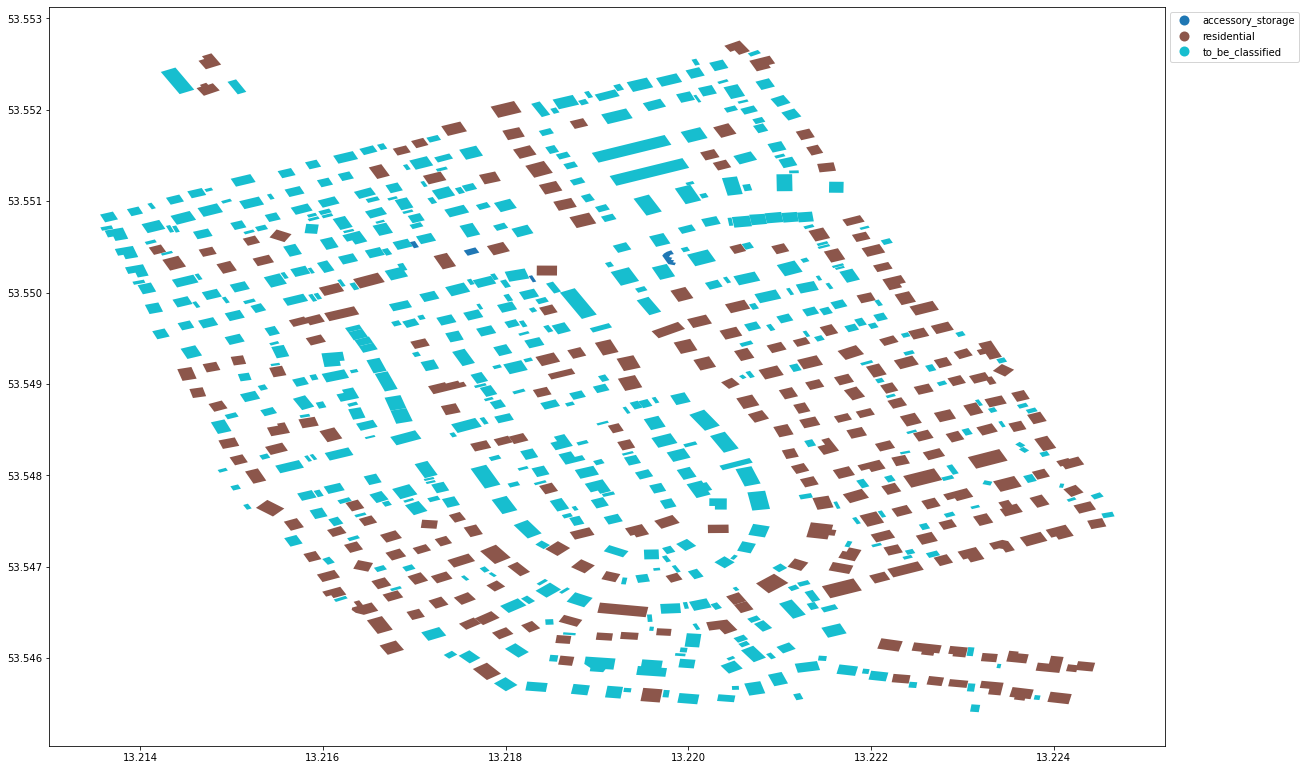

In [196]:
bc.plot_buildings_area(buildings_block_df, 
                       plot_type = 'building_types',
                       legend_ncol = 1)

In [197]:
generate_stats_table(buildings_block_df)

,building_types,count,mean_rectangularity,mean_surface_area,sd_surface_area,sd_rectangularity
0,accessory_storage,4,70.007075,0.510449,0.039070,36.113868
1,residential,245,204.158873,0.591913,0.072749,73.448270
2,to_be_classified,507,123.558746,0.572578,0.091551,108.176723


In [143]:
buildings_block_df[buildings_block_df.building_types =='to_be_classified'].rectangularity.iloc[1]

332.5841500050754

In [167]:
df = buildings_block_df['rectangularity'].to_list()

In [168]:
diff_func = lambda p1, p2: abs(p1-p2)
dm = np.asarray([[diff_func(p1, p2) for p2 in df] for p1 in df])

In [172]:
dm

array([[  0.        , 225.62575001,  38.3906    , ...,  63.78275   ,
         41.68345   ,  27.9615    ],
       [225.62575001,   0.        , 264.01635001, ..., 289.40850001,
        267.30920001, 253.58725   ],
       [ 38.3906    , 264.01635001,   0.        , ...,  25.39215   ,
          3.29285   ,  10.4291    ],
       ...,
       [ 63.78275   , 289.40850001,  25.39215   , ...,   0.        ,
         22.0993    ,  35.82125   ],
       [ 41.68345   , 267.30920001,   3.29285   , ...,  22.0993    ,
          0.        ,  13.72195   ],
       [ 27.9615    , 253.58725   ,  10.4291    , ...,  35.82125   ,
         13.72195   ,   0.        ]])

### Random forest to assign building types

Creating training dataset using features:
- Rectangularity
- Surface area
- Building block (from HDBSCAN result)

Target variable is **building_types** from naive classification

In [201]:
buildings_clust_df.columns

Index(['type', 'id', 'nodes', 'center.lat', 'center.lon', 'tags.building',
       'building_levels', 'tags.source', 'tags.addr:city',
       'tags.addr:housenumber', 'ags', 'tags.addr:street', 'tags.addr:suburb',
       'geometry', 'timestamp', 'building_types', 'surface_area',
       'rectangularity', 'total_area', 'building_block'],
      dtype='object')

In [235]:
# df = buildings_clust_df[buildings_clust_df.building_types.isin(['to_be_classified','residential'])]
df = buildings_clust_df

In [237]:
# One-hot-encoding building types
ohc_bld_type = pd.get_dummies(df[['building_types']])
df = pd.concat([df.drop(columns = 'building_types') ,ohc_bld_type], axis = 1)

In [217]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Labels are the values we want to predict
labels = np.array(df['building_types'])

# Remove the labels from the features
# axis 1 refers to the columns
features= df[['rectangularity','surface_area','building_block']]

# Convert to numpy array
features = np.array(features)


In [212]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [213]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (74400, 3)
Training Labels Shape: (74400,)
Testing Features Shape: (24800, 3)
Testing Labels Shape: (24800,)


In [214]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

ValueError: could not convert string to float: 'to_be_classified'

# DEV

## Plot naive vs hdbscan result (1 AGS for Medium article example only)

In [16]:
# Plot settings
plt.rcParams['axes.facecolor'] = 'white'

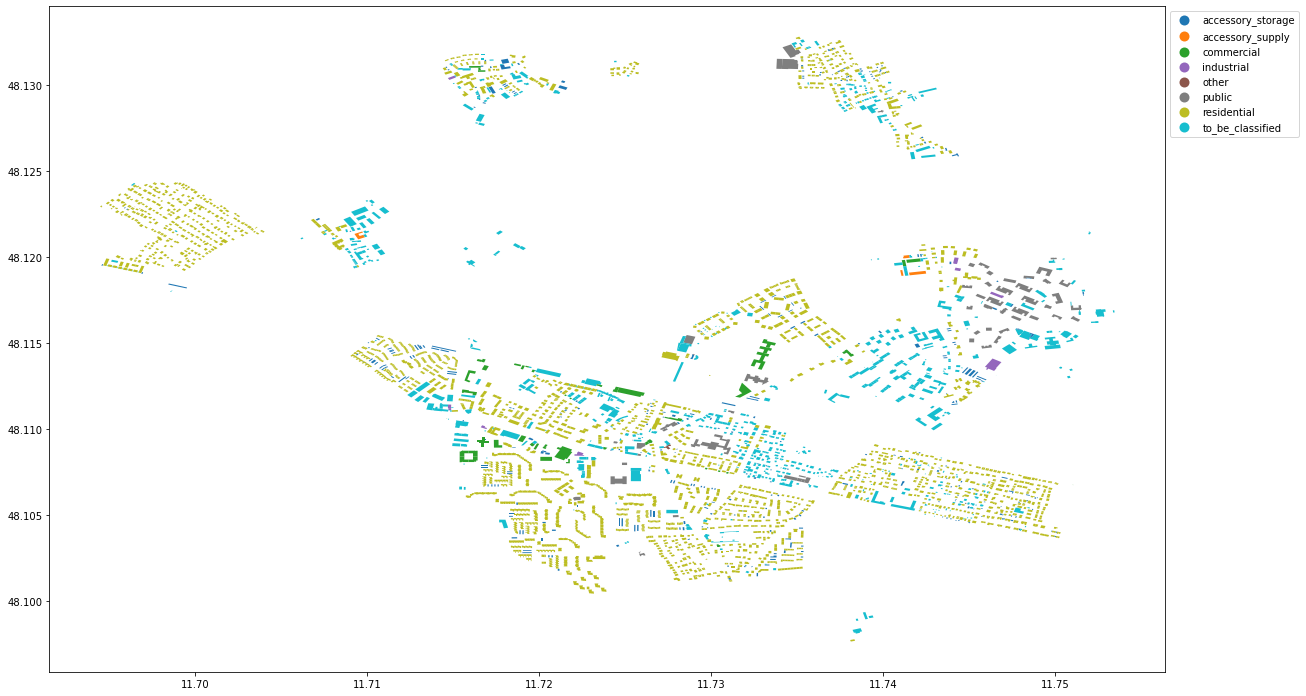

In [17]:
bc.plot_buildings_area(buildings_clust_df, 
                       plot_type = 'building_types',
                       legend_ncol = 1)

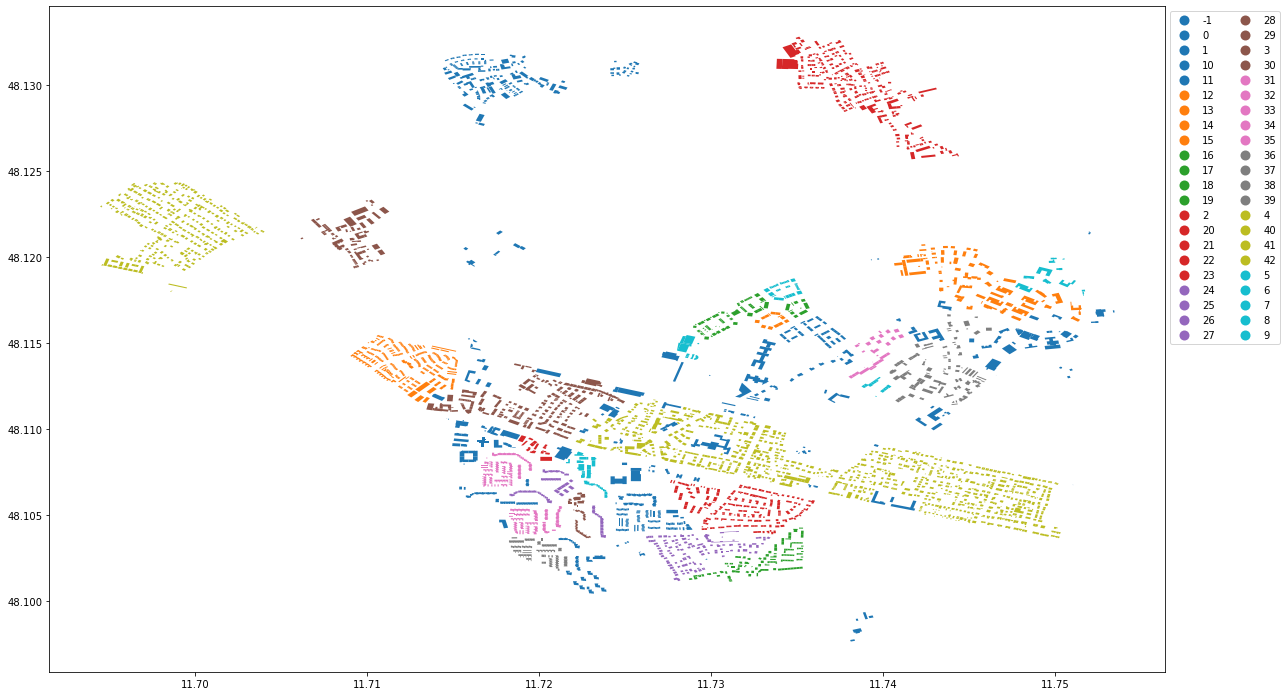

In [18]:
bc.plot_buildings_area(buildings_clust_df, 
                       plot_type = 'building_block',
                       legend_ncol = 2)

## Calculate Hausdorff distance between geometries (dev)


In [19]:
from hausdorff import hausdorff_distance
from shapely import wkt
from geopandas import GeoDataFrame

In [20]:
buildings_clust_df.geometry.iloc[1]

'POLYGON ((11.7282493 48.1150021, 11.7287507 48.1149024, 11.7287133 48.1148185, 11.7285527 48.1144583, 11.7280512 48.114558, 11.7282493 48.1150021))'

In [21]:
df = buildings_clust_df
# Filter out NaN
df = df[df.geometry.isna() == False].reset_index(drop = True)

# Convert geometry to GeoSeries
df['geometry'] = df['geometry'].apply(wkt.loads)
# Convert to GeoPandas type
df_geo = GeoDataFrame(df, geometry='geometry')

In [22]:
hausdorff_distance(np.array(df_geo.geometry.iloc[0].exterior.coords),
                   np.array(df_geo.geometry.iloc[1].exterior.coords))*(10**4)

5.86013353090282

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);